#### Hard Voting Classifier

We can create a better classifier by aggregating the predictions of each classifier and predict the class that gets the most votes. It is known as hard voting classifier.


Ensemble methods work best when the predictors are as independent from one another as possible. 

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver='liblinear', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma='auto', random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')


In [2]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(random_state=42,
                                                 solver='liblinear')),
                             ('rf',
                              RandomForestClassifier(n_estimators=10,
                                                     random_state=42)),
                             ('svc', SVC(gamma='auto', random_state=42))])

In [4]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.85
RandomForestClassifier 0.88
SVC 0.87
VotingClassifier 0.87


#### Soft Voting Classifier

It is method where the predictions of multiple individual models are combined to make a final prediction. It achieves higher performance than voting because it gives more weight to highly confident votes.  

In [5]:
log_clf = LogisticRegression(solver='liblinear', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma='auto', probability=True,  random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')

In [6]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.85
RandomForestClassifier 0.88
SVC 0.87
VotingClassifier 0.9


### Bagging and Pasting

Bagging uses the same training algorithm for every predictor, but to train them on different random subsets of the training set by sampling with replacement(Bootstraping). But if sampling is performed without replacement, it is called pasting.

Scikit-learn offers BaggingClassifier class or BaggingRegressor class for both bagging and pasting. For pasting we can state the bootstrap hyperparameter to False. 

The BaggingClassifier automatically performs soft voting instead of hard voting if the base classifier can estimate class probabilities.

Bootstrapping introduces a bit more diversity in the subsets that each predictor is trained on, so bagging ends up with a slightly higher bias than pasting, but predictors end up being less correlated so the ensemble's variance is reduced. Overall, bagging often results in better models.

In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
            DecisionTreeClassifier(), n_estimators=500,
            max_samples=100, bootstrap=True)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [9]:
print(accuracy_score(y_test, y_pred))

0.89


### Out-of-Bag Evaluation

With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all. The probability of not selecting n samples in n draws is (1-1/n)^n. When the value is big, we can approximate this probability to 1/e, which is 0.3678. This means when the dataset is big enough, 37% of its samples are never selected and we could use it to test our model. This is called Out-of-Bag Scoring, or OOB Scoring.

In Scikit-learn, we can set oob_score=True when creating a BaggingClassifier to request an automatic oob evaluation after training.

In [10]:
bag_clf = BaggingClassifier(
                DecisionTreeClassifier(), n_estimators=500,
                bootstrap=True, oob_score=True)

bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=500,
                  oob_score=True)

In [11]:
bag_clf.oob_score_

0.915

In [12]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.89

In [13]:
bag_clf.oob_decision_function_ # it returns the class probabilites for each training instance

array([[0.98941799, 0.01058201],
       [0.        , 1.        ],
       [0.05527638, 0.94472362],
       [0.92307692, 0.07692308],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.99428571, 0.00571429],
       [0.65555556, 0.34444444],
       [0.54098361, 0.45901639],
       [0.00534759, 0.99465241],
       [0.5989011 , 0.4010989 ],
       [0.86885246, 0.13114754],
       [1.        , 0.        ],
       [0.00510204, 0.99489796],
       [0.52791878, 0.47208122],
       [0.97674419, 0.02325581],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.99444444, 0.00555556],
       [0.03208556, 0.96791444],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.78010471, 0.21989529],
       [1.        , 0.        ],
       [0.71282051, 0.28717949],
       [0.39779006, 0.60220994],
       [0.29508197, 0.70491803],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.

#### Random Patches and Random Subspaces

The BaggingClassifier class supports sampling the features as well. This can be controlled by two hyperparameters: max_features and bootstrap_features. 
This is useful when dealing with high-dimensional inputs such as images. 

Sampling both training instances and features is called the Random Patches method.

Keeping all training instances (i.e. bootstrap=False and max_samples=1) but sampling features (i.e. bootstrap_features=True and/or max_features smaller than 1) is called the Random Subspaces method.

Sampling features results in even more predictor diversity, trading a bit more bias for a lower variance.

### Random Forests

In [14]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16)
rnd_clf.fit(X_train, y_train)

y_pred = rnd_clf.predict(X_test)

#### Extra-Trees

We can make trees more random by using random thresholds for each feature rather than searching for the best possible thresholds and it is called an Extremely Randomized Trees ensemble or Extra-Trees. But this trades more bias for a lower variance. It also makes Extra Trees much faster to train than regular Random Forest since finding the best possible threshold for each feature at every node is time consuming.

We can create an Extra-Trees Classifier using Scikit-learn's ExtraTreesClassifier class. 

In [17]:
from sklearn.ensemble import ExtraTreesClassifier

extra_tree_clf = ExtraTreesClassifier(n_estimators=500)
extra_tree_clf.fit(X_train, y_train)

y_pred_extra_tree = extra_tree_clf.predict(X_test)

In [19]:
accuracy_score(y_test, y_pred_extra_tree)

0.87

#### Feature Importance

In Decision Tree, important features are likely to appear closer to the root of the tree, while unimportant features will often appear closer to the leaves. 

In [20]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500)
rnd_clf.fit(iris["data"], iris["target"])

RandomForestClassifier(n_estimators=500)

In [21]:
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09461124475251456
sepal width (cm) 0.023138774929102046
petal length (cm) 0.43433141095148736
petal width (cm) 0.44791856936689595


In [23]:
from sklearn.datasets import fetch_openml
import numpy as np

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.int64)

In [25]:
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(n_estimators=10, random_state=42)

In [27]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_digit(data):
    img = data.reshape(28, 28)
    plt.imshow(img, cmap=mpl.cm.hot, interpolation='nearest')
    plt.axis("off")

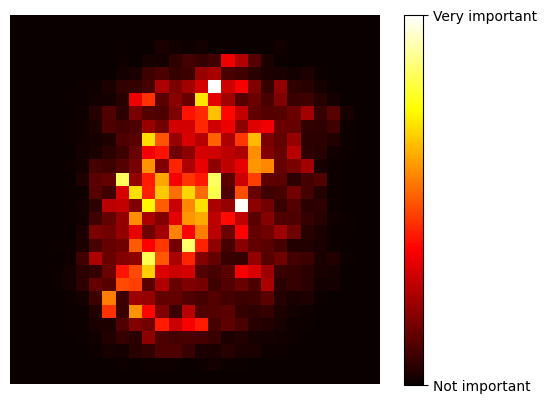

In [30]:
plot_digit(rnd_clf.feature_importances_)
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()